In [ ]:
# @title Set Global Values
TRAIN_DATA_PATH = "" # Training set not provided.
OPENAI_API_KEY = "" # Keep it hidden!
OPENAI_MODEL_ID = "" # Whatever ID OpenAI gives out after fine-tuning a model.
SCP_ARTICLE_TABLE_PATH = "" # An AI generated SCP .csv table.
SCP_IMGS_PATH = "" # AI generated imgs folder.
SCP_PAGES_PATH = "" # The path for generated SCP article htmls.
IMGS_HOSTING_PATH = "" # For example if "www.imghost.com/" is the path, must have imgs hosted as : /1.png, /2.png at the end.

In [ ]:
# @title Requirements

!pip install transformers==4.21.0
!pip install datasets
!pip install tqdm
!pip install openai
!pip install diffusers
!pip install accelerate
!pip install Jinja2
!pip install pandas
!pip install seaborn

# SCP text generation

## Training model

In [ ]:
# @title Prep from table data

# We clean the dataset. For ex: too long/short, bad ratings, bad format, string issues...

import pandas as pd
import numpy as np
import seaborn as sns
import csv

df = pd.read_csv(TRAIN_DATA_PATH, delimiter=',', quoting=csv.QUOTE_ALL, encoding='utf-8', index_col=0)

prep_df = df[df["text"].str.startswith("\"Item #: SCP-")]
prep_df = prep_df[prep_df["text"].str.contains("Object Class:")]
prep_df = prep_df[prep_df["text"].str.contains("Special Containment Procedures:")]
prep_df = prep_df[prep_df["text"].str.contains("Description:")]

prep_df = prep_df[(prep_df["rating"]>30)]


prep_df['text'] = prep_df["text"].str[1:]  # Remove quotations from text and title
prep_df['title'] = prep_df["title"].str[1:-1]

prep_df['text'] = prep_df['text'].str.split(" \n « SCP-").str[0] # Clean site data at end of text
prep_df['text'] = prep_df['text'].str.split("\n Uncle Nicolini's Works").str[0]

prep_df['text'] = prep_df['text'].str.replace(" \\n ", "\\n", regex=True) # Remove spaces surrounding new lines.
prep_df["text"] = prep_df["text"].str.replace(r'([a-zA-Z]+\.?)[0-9]+', r'\1', case=False, regex=True) # Clean buggy leftover footnotes (like "food1")

len(prep_df)

### Explore

We look at missing data, spread of article length and ratings.

In [ ]:
df.isnull().sum()

Unnamed: 0           0
code                 0
title                0
text                 0
image captions    3894
rating             388
link                 0
image_url         4418
dtype: int64

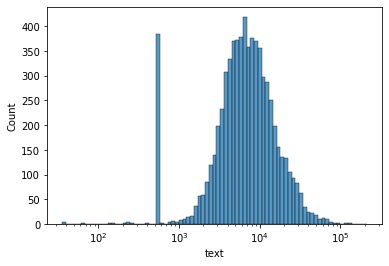

In [ ]:
sns.histplot(df["text"].str.len(), log_scale=True)

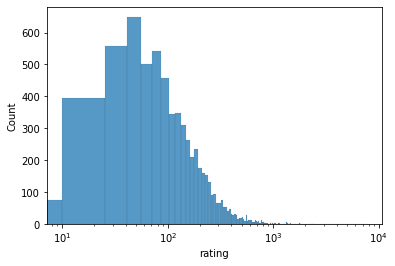

In [ ]:
plot = sns.histplot(df["rating"].dropna())
plot.set_xscale("log")

### Fine-tuning (GPT-3)

In [ ]:
#@title Prep corpus
from transformers import GPT2TokenizerFast
import json

def train_test_split(df, frac=0.1):
    test = df.sample(frac=frac, random_state=42, axis=0)
    train = df.drop(index=test.index)
    return train, test

def prepare_dataset(df):
  tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")
  df["prompt"] = "Title:" 
  df["completion"] = " " + df["title"] + "\n"+ " " + df["text"] + "<|endoftext|>"
  df = df[(df['prompt']+df["completion"]).map(lambda x: len(tokenizer.encode(x))<2048)] #Keep entries < 2048 tokens.
  return df[["prompt", "completion"]]

def write_df_to_jslon(df, filename):
  with open(filename+".jsonl", 'w') as fp:
      fp.write('\n'.join(json.dumps(i) for i in df.to_dict("records")))

train_df, validate_df = train_test_split(prepare_dataset(prep_df))
write_df_to_jslon(train_df, "scp_train")
write_df_to_jslon(validate_df, "scp_validate")

Token indices sequence length is longer than the specified maximum sequence length for this model (1038 > 1024). Running this sequence through the model will result in indexing errors


In [ ]:
# @title Train model 
import openai
SUFFIX = "scp-fine-tune"

!openai --api-key $OPENAI_API_KEY api fine_tunes.create \
-t /content/scp_train.jsonl \
-v /content/scp_validate.jsonl \
-m curie \
--n_epochs 2 \
--learning_rate_multiplier 0.2 \
--suffix $SUFFIX

In [ ]:
#@title Test 
generation = openai.Completion.create(
    model = OPENAI_MODEL_ID
    prompt="Title: Grandfather Clock\n")

## Generating SCPs

In [19]:
import pandas as pd
import random
import openai
from transformers import GPT2TokenizerFast

openai.api_key = (OPENAI_API_KEY)

class SCP:
  def __init__(self, title=None, number=None, object_class=None, 
               containment=None, description=None, addendums=[]):
    self.title = title
    self.number = number
    self.object_class = object_class
    self.containment=containment
    self.description=description
    self.addendums=addendums

  def to_dict(self):
    return {
        'title': self.title,
        'number': self.number,
        'object_class': self.object_class,
        'containment': self.containment,
        'description': self.description,
        'addendums': self.addendums,
        }


# Generates SCPs, handles the controllability of article sub-sections.
class SCPGenerator:
  def __init__(self, model):
    self.model = model
    self.current_generation = ""
    self.end_reached = False
    self.tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")

  # Returns how many tokens left until model context window is capped.
  def tokens_left(self, prompt):
    max_tokens = 2048
    return max(0, max_tokens-len(self.tokenizer.encode(prompt)))

  def generate_title(self):
    prompt = "Title:"
    output = ""
    while output == "":
      generation = openai.Completion.create(model=self.model, prompt=prompt, 
                                            max_tokens=20, stop= ["\n","Item"])
      output = generation["choices"][0]["text"]
    return output if output[0] != " " else output[1:]

  def generate_number(self):
    return random.randint(1, 9999)

  def generate_object_class(self):
    prompt = self.current_generation + "\nObject Class:"
    generation = openai.Completion.create(model=self.model, prompt=prompt, 
                                          max_tokens=4, top_p=0.99,
                                          stop= ["\n","Description","Special Containment"])
    return generation["choices"][0]["text"][1:]

  def generate_containment(self):
    prompt = self.current_generation + "\nSpecial Containment Procedures:"
    tokens_left = self.tokens_left(prompt)
    if tokens_left==0: return None
    generation = openai.Completion.create(model=self.model, prompt=prompt, 
                                          max_tokens=tokens_left, temperature=0.7,
                                          frequency_penalty=0.2, presence_penalty=0.6,
                                          stop=["\nDescription","\nAddendum","Special Containment"])
    output = generation["choices"][0]["text"]
    return output if output[0] != " " else output[1:]

  def generate_description(self):
    prompt = self.current_generation + "\nDescription:"
    
    tokens_left = self.tokens_left(prompt)
    if tokens_left==0: return None
    generation = openai.Completion.create(model=self.model, prompt=prompt,
                                          max_tokens=tokens_left, temperature=0.7, 
                                          frequency_penalty=0.2, presence_penalty=0.6,
                                          stop=["\nAdd", "\nExp","\nDes","<|endoftext|>"], logprobs=5)
    logprobs = generation["choices"][0]["logprobs"]["top_logprobs"]
    for logprob in logprobs[-2:]:
      if ("<|endoftext|>") in list(logprob.keys()):
        self.end_reached = True

    output = generation["choices"][0]["text"]
    return output if output[0] != " " else output[1:]

  def generate_addendum(self):
    prompt = self.current_generation + "\nAdd"
    tokens_left = self.tokens_left(prompt)
    if tokens_left==0: 
      self.end_reached = True
      return None, False

    generation = openai.Completion.create(model=self.model, prompt=prompt, 
                                          max_tokens=tokens_left, temperature=0.8, 
                                          frequency_penalty=0.25, presence_penalty=0.5,
                                          stop=["\nAdd", "<|endoftext|>"], logprobs=5)
    logprobs = generation["choices"][0]["logprobs"]["top_logprobs"]
    addendum_complete = False
    for logprob in logprobs[-4:]:
      if any(x in ["Add", "endum"] for x in list(logprob.keys())):
        addendum_complete = True
      if ("<|endoftext|>") in list(logprob.keys()):
        self.end_reached, addendum_complete = True, True
      
    output = generation["choices"][0]["text"]
    return output, addendum_complete

  def generate_addendums(self, max=3):
    addendums = []
    while not self.end_reached and len(addendums)<max:
      addendum, addendum_complete = self.generate_addendum()
      if addendum is not None and addendum_complete:
        addendums.append("Add"+addendum)
        self.current_generation+=("Add" + addendum + "\n")
      else:
        break
    return addendums

  def generate_scp(self, scp=None):
    if scp is None: scp=SCP()

    self.current_generation = ""
    self.end_reached = False

    title = self.generate_title() if (scp.title is None) else scp.title
    self.current_generation+=("Title: " + title +"\n")

    number = self.generate_number() if (scp.number is None) else scp.number
    self.current_generation+=("Item #: SCP-" + str(number) +"\n")
    
    object_class = self.generate_object_class() if (scp.object_class is None) else scp.object_class
    self.current_generation+=("Object Class: " + object_class +"\n")

    containment = self.generate_containment() if (scp.containment is None) else scp.containment
    self.current_generation+=("Special Containment Procedures: " + containment + "\n")

    description = self.generate_description() if (scp.description is None) else scp.description
    self.current_generation+=("Description: " + description + "\n")

    addendums = self.generate_addendums() if not scp.addendums else scp.addendums 

    print(self.current_generation)
    return SCP(title,number,object_class,containment,description,addendums)


# Generates, manages and saves the SCPs articles. 
class SCPDatabaseBuilder:
  def __init__(self, model, csv_path):
    self.generator = SCPGenerator(model)
    self.csv_path = csv_path
    try:
      self.load_scps()
    except:
      self.scps = pd.DataFrame(columns=["title", "number", "object_class", 
                                        "containment", "description", "addendums"])
      self.scps = self.scps.set_index("number")

  def add_scp(self, scp):
    scp_dict = scp.to_dict()
    if scp.number in self.scps.index:
      self.scps.loc[scp.number] = scp_dict

    else:
      scp_df = pd.DataFrame.from_dict(scp_dict,orient='index').T.set_index("number")
      self.scps = pd.concat([self.scps, scp_df])

  def get_scp(self, number):
    scp = self.scps.loc[number]
    return SCP(scp.title, number, scp.object_class, 
               scp.containment, scp.description, scp.addendums)
    
  def get_all_scps(self):
    return [SCP(**kwargs) for kwargs in self.scps.to_dict(orient='records')]

  def save_scps_to_file(self):
    self.scps.to_csv(self.csv_path, sep=';', encoding='utf-8', index=False)

  def load_scps(self):
    self.scps = pd.read_csv(self.csv_path, sep=';', encoding='utf-8')
    self.scps.index+=1

  def generate_scp(self, scp=None):
    if scp is None: scp=SCP()
    if scp.title is None:
      scp.title = self.generator.generate_title()
      while self.scps["title"].eq(scp.title).any():
        scp.title = self.generator.generate_title()
    
    if scp.number is None: scp.number = len(self.scps.index)+1
    scp = self.generator.generate_scp(scp)
    self.add_scp(scp)

  def generate_scps(self, count=1, save_interval=0):
    for i in range(count):
      try:
        self.generate_scp()
        if save_interval!=0: 
          if i % save_interval: self.save_scps()
      except:
        i-=1
        pass

In [20]:
# Create an SCP database
csv_path = SCP_ARTICLE_TABLE_PATH
model = OPENAI_MODEL_ID
database_builder = SCPDatabaseBuilder(model, csv_path)

In [ ]:
# Generate an SCP. Here, with a given title and number.
scp = SCP("Grand Grandfather Clock", 6)
database_builder.generate_scp(scp)

In [ ]:
# Save all the database builder has stored to a file, when you are done generating SCP articles.
database_builder.save_scps_to_file()

# SCP image generation

In [ ]:
# @title Generate images
import torch
import re
import accelerate
from diffusers import StableDiffusionPipeline

class SCPImageGenerator:
  def __init__(self, model, output_folder):
    self.model = model
    self.output_folder = output_folder
    self.generator = torch.Generator("cuda").manual_seed(1024)
    self.neg_prompt = "illustration, naked, error, cropped, jpeg artifacts, signature, watermark, username"

  def extract_appearance(self, scp):
    appearance = None
    regex = r'((SCP-)\d*(-\d+)?) (is an?|ressembles|appears).{1,230}\.'
    appearance_match = re.search(regex, scp.description)
    if appearance_match is not None:
      appearance = re.sub(r'((SCP-)\d*(-\d+)?)', r'it', appearance_match[0])
    print(appearance)
    return appearance

  def prepare_prompt(self, scp):
    prompt = None
    appearance= self.extract_appearance(scp)
    if appearance is not None:
      prompt = "Title: " + scp.title + " Description: " + appearance
    return prompt 

  def generate_scp_image(self, scp, number=None):
    prompt = self.prepare_prompt(scp)
    if prompt is not None:
      with torch.autocast("cuda"):
        image = model(prompt, height=512, width=576,negative_prompt = self.neg_prompt,
                      guidance_scale=7,num_inference_steps=30, generator=self.generator).images[0]
      if number is None:
        number = scp.index
      output_path = f"%s/%s.png" % (self.output_folder, str(number))
      image.save(output_path)
      return image

  def generate_scp_images(self, scps):
    for i in range(len(scps)):
      self.generate_scp_image(scps[i], i+1)


model = StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5").to("cuda")
output_folder = SCP_IMGS_PATH
img_generator = SCPImageGenerator(model, output_folder)

In [ ]:
# Generates images from an already generated SCP database.
img_generator.generate_scp_images(database_builder.get_all_scps())

In [ ]:
# When done, unload diffusion model (heavy RAM use)
import gc
torch.cuda.empty_cache()
gc.collect()

# SCP Page generation

## Defining Templates

In [21]:
from jinja2 import Template, Environment
import jinja2
import IPython
import re

def regex_replace(s, find, replace):
    return re.sub(find, replace, s)

env = Environment() # main environment, basically one per program.
env.filters['regex_replace'] = regex_replace

t = env.from_string("""---
scp: "{{  number  }}"
---

<head>
    <title>{{  number  }} - SCP Foundation</title>
    
    <style type="text/css" id="internal-style">
                
        /* theme */
                    @import url(https://d3g0gp89917ko0.cloudfront.net/v--291054f06006/common--theme/base/css/style.css);
                    @import url(https://scp-wiki.wdfiles.com/local--code/component%3Atheme/1);
            
            </style>
<style>
iframe.scpnet-interwiki-frame { height: 0; }
</style>

</head>

<div id="main-content" style="margin: 50px 206px 20px 215px;">
<div id="action-area-top"></div>
<div id="page-title">SCP-{{ number }}</div>
<div id="page-content">
<div style="text-align: right;"></div>
<div class="scp-image-block block-right" style="width:300px;"><img src="https://raw.githubusercontent.com/lucmaki/this-scp-does-not-exist/main/imgs/{{ number }}.png" style="width:300px;" alt="{{ number }}.jpg" class="image">
<div class="scp-image-caption" style="width:300px;">
<p>Picture of SCP-{{ number }}.</p>
</div>
</div>
<p><strong>Item #:</strong> SCP-{{ number }}</p>
<p><strong>Object Class:</strong> {{ object_class }}</p>
<p><strong>Special Containment Procedures:</strong> {{ containment  | replace("\n", "</p><p>") }}</p>
<p><strong>Description:</strong> {{ description  | replace("\n", "</p><p>") }}</p>
<p> {{ addendums  | replace("\n", "</p><p>") }}</p>

<div class="footer-wikiwalk-nav">
<div style="text-align: center;">
</div>
</div>
</div>
</div>
</div>""")

## Generating Pages

In [27]:
import re

class SCPPageGenerator:
  def __init__(self, output_path, img_folder_path):
    self.output_path = output_path
    self.img_folder_path = img_folder_path

  def fill_html_template(self, scp, img_path):
    dict = {"img_src": img_path, "number": scp.number, "object_class": scp.object_class,
        "containment": scp.containment, "description": scp.description,
        "addendums": re.sub(r'(^|\n|\\n)(.{3,25}:)(\D)', r'\1<strong>\2</strong>\3',
                            re.sub(r'(\', \'|\\n)', r'\n', scp.addendums[2:-2]))
        }
    return t.render(dict)

  def generate_scp_html(self, scp):
    number = str(scp.number)
    img_path = self.img_folder_path+"/"+number+".png"

    html = self.fill_html_template(scp, img_path)
    return html

  def generate_scps_htmls(self, database_builder):
    htmls=[]
    for i in range(len(database_builder.get_all_scps())):
      html = self.generate_scp_html(database_builder.get_scp(i+1))
      htmls.append(html)
    return htmls

page_generator = SCPPageGenerator(SCP_PAGES_OUTPUT_PATH, SCP_IMGS_PATH)

In [29]:
# Bulk generates SCP web pages out of already generated articles and images.

pages = page_generator.generate_scps_htmls(database_builder)

for i in range(len(pages)):
  page_path = SCP_PAGES_OUTPUT_PATH + str(i+1) +".html"
  with open(page_path, 'w') as f:
    f.write(pages[i])